## Managing velocities

In [1]:
#load in parent stuff

import nb_load_stuff
from tectModelClass import *

importing Jupyter notebook from tectModelClass.ipynb


In [2]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import os
import sys

if os.getcwd() == '/workspace/newSlab':
    sys.path.append('../unsupported')

#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../unsupported')
except:
    pass

In [3]:
#from unsupported_dan.UWsubduction.base_params import *
#from unsupported_dan.UWsubduction.subduction_utils import *
from unsupported_dan.interfaces.marker2D import markerLine2D, line_collection


from unsupported_dan.UWsubduction.base_params import *
from unsupported_dan.UWsubduction.subduction_utils import *

../unsupported/unsupported_dan/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [4]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator




## Physical model

In [5]:
yres = int(md.res)
xres = int(md.res*12) 

mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = (ndp.leftLim, 1. - ndp.depth), 
                                 maxCoord    = (ndp.rightLim, 1.)) 

temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)

In [6]:
#(1. - mesh.minCoord[1])*2900

## Build plate model

In [7]:
#Set up some velocityies
cm2ms = (1/100.)*(1./(3600*24*365)) 

v1= 2.*cm2ms #m/s
v1 /= sf.velocity

v2= -2.*cm2ms #
v2 /= sf.velocity



ma2s = 1e6*(3600*24*365)
endTime = 20*ma2s/sf.time
dt = 0.1*ma2s/sf.time
testTime = 5*ma2s/sf.time


In [8]:
#20 Ma moddel, timestep of 200 Ka 
tg = TectModel(mesh, 0, endTime, dt)

tg.add_plate(1, velocities = v1)
tg.add_plate(2,velocities = v2)
tg.add_plate(3, velocities = v2/2.)

In [9]:
tg.add_left_boundary(1)
tg.add_subzone(1, 2, ndp.subZoneLoc, subInitAge=ndp.slabMaxAge, upperInitAge=ndp.opMaxAge)
tg.add_subzone(3, 2, 0.4, subInitAge=ndp.slabMaxAge, upperInitAge=ndp.opMaxAge)

tg.add_right_boundary(3, 0.)

## Querying the velocities

In [10]:
time=tg.times[10]
for n in tg.nodes():
    if tg.plate_has_vel(n, time):
        print('plate {} has specified vel={}'.format(n, tg.plate_velocity(n, time) ))
    else:
        print('plate {} has no specified vel'.format(n))
    

for e in tg.undirected.edges():
    #print(e)

    if tg.is_subduction_boundary(e):
        n = tg.subduction_edge_order(e)[1]
        
        if tg.upper_plate_has_vel(e, time):
             print('upper plate {} has specified vel={}'.format(n, tg.plate_velocity(n, time) ))        

plate 1 has specified vel=1839.16793506
plate 2 has specified vel=-1839.16793506
plate 3 has specified vel=-919.583967529
upper plate 2 has specified vel=-1839.16793506
upper plate 2 has specified vel=-1839.16793506


## Test nodes and Vel Fn

In [11]:
#set vel to some preexiting value
velocityField.data[:] = 500.

In [12]:
tg.get_edge_data(*(2, 3))

In [13]:
dist = 100e3/sf.lengthScale

subMaskFn = tg.plate_boundary_mask_fn(dist)
#subMaskFn = tg.plate_boundary_mask_fn(0.1, bound=(1,2))

In [14]:
#nodes = tg.get_vel_nodes(pNodeIdFn) 
#nodes = tg.plate_vel_node_fn(testTime, maskFn = MaskFn)

In [15]:
#tg.plate_id_fn( maskFn = MaskFn)
#tg.plate_vel_node_fn(testTime, maskFn = MaskFn)

In [16]:
#type(MaskFn) == uw.function.branching.conditional

In [18]:
## test Plate Vel node fn
dist = 100e3/sf.lengthScale
MaskFn = tg.subduction_mask_fn(dist)
#MaskFn = tg.plate_boundary_mask_fn(dist)


#getting the nodes is a two step proceedure, 
#first build an id function (similar to the pateIdFn but masked for any plate where viscosity is not set)
#pNodeIdFn = tg.plate_vel_node_fn(testTime, maskFn = subMaskFn)

#not that we could connect these two fuctions
nodes = tg.plate_vel_node_fn(testTime, maskFn = MaskFn)


#thsi returns only the nodes which we haven't masked, where the velocity is set
#nodes = tg.get_vel_nodes(pNodeIdFn) 

float(len(nodes))/(mesh.elementRes[0] + 1)
locs = tg.mesh.data[nodes]

In [19]:
#Build the required functions to actually set the velocity
pIdFn = tg.plate_id_fn()
velMapFn = tg.plateVelFn(testTime, pIdFn)

#Now set the veolcity on the nodes
velocityField.data[nodes, 0] = velMapFn.evaluate(locs)[:,0]

In [20]:
#fig = glucifer.Figure(figsize=(400, 200))
#fig.append( glucifer.objects.Surface(tg.mesh, subMaskFn ))
#fig.show()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


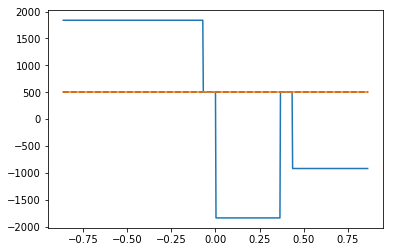

In [21]:
#check
%pylab inline
tWalls = tg.mesh.specialSets['MaxJ_VertexSet']

fig, ax = plt.subplots()
plt.plot(mesh.data[tWalls.data][:,0], velocityField.data[tWalls.data])

ax.hlines(500, tg.minX, tg.maxX, linestyles='--')


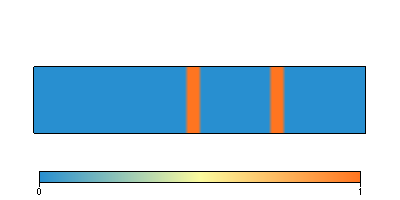

In [22]:
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, MaskFn))

fig.show()

## Updating graph based on velocity information

In [21]:
tmUwMap = tm_uw_map([], velocityField, [], 
                    [], [], [])

In [22]:
from tectModelClass import mid_plate_point_vel

In [23]:
for n in tg.nodes():
    print('mid-plate-vel is {}'.format(mid_plate_point_vel(tg, n, tmUwMap))  )

mid-plate-vel is [[ 1839.16793506   500.        ]]
mid-plate-vel is [[-1839.16793506   500.        ]]
mid-plate-vel is [[-919.58396753  500.        ]]


In [24]:
bounds = [-0.86206897, -0.03448276]
max(0., bounds[1] - bounds[0])

0.82758621


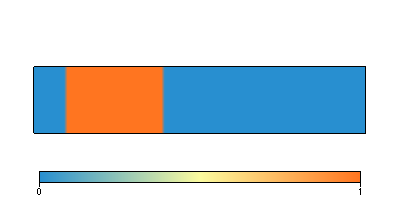

In [25]:
piFn = tg.plate_interior_mask_fn(boundaryFactor=0.6, minPlateLength=0.4, plate =1)


fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, tg.b2f(piFn)))
fig.show()

In [26]:
test = tg.interior_mask_fn_dict(boundaryFactor=0.6)


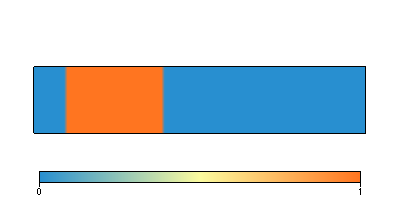

In [27]:
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, test[1] ))
fig.show()

In [28]:
#test = tg.interior_mask_fn_dict(boundaryFactor=0.6,  out = 'num')

In [29]:
#out = plate_integral_vel(tg, tmUwMap, test.values())

In [30]:
#dict(zip(test.keys(), out))

In [31]:
dist = 100e3/sf.lengthScale
MaskFn = tg.subduction_mask_fn(dist)


In [32]:
srLocMins, srLocMaxs = strain_rate_min_max(tg, tmUwMap, tg.b2f(MaskFn))

In [33]:
srLocMins

[(0.0, -0.86206896551699996)]

In [35]:
tg.is_subduction_boundary((1,2))

True

In [36]:
tg.is_self_loop((1,1))

In [37]:
tg.set_bound_loc((1,1))

TypeError: set_bound_loc() takes exactly 3 arguments (2 given)

In [38]:
tg.get_bound_loc((1,1))

-0.8620689655172414